<a href="https://colab.research.google.com/github/mokoron/EDA/blob/master/BFG_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
from google.colab import drive
drive.mount('/drive/')

In [3]:
%%capture
ls '/drive/My Drive/BFG'

In [4]:
%%capture
!wget  -O "Roboto.zip" "https://fonts.google.com/download?family=Roboto"

In [ ]:
%%capture
!unzip "Roboto.zip"

In [ ]:
%%capture
!mv Roboto-Light.ttf  /usr/share/fonts/truetype/

In [ ]:
%%capture
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/Roboto-Light.ttf'
fontprop = fm.FontProperties(fname=path, size= 12)
fontprop_title = fm.FontProperties(fname=path, size= 32)
fontprop_axis = fm.FontProperties(fname=path, size= 20)

In [ ]:
import pandas as pd

from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
colorscale = [[0, '#7BC100'],[0.5, '#d8f5a9'],[1, '#ffffff']]

import plotly.graph_objects as go
from plotly.colors import n_colors
import numpy as np
from plotly.subplots import make_subplots
import re

In [ ]:
from collections import Counter
from plotly.offline import init_notebook_mode, iplot

In [ ]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import io
import plotly.express as px
from statistics import mean
%matplotlib inline

In [ ]:
def freq_diagram(x, y, data_df, x_label, y_label, bp_name):
  f, ax = plt.subplots(figsize=(25, 7))
  bp = sns.barplot(x=x, y=y, data=data_df,
              palette=sns.light_palette("#7bc100", reverse=True, n_colors=len(set(list(data_df[x])))))
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(bp_name)
  bp = bp.set_xticklabels(labels = list(data_df[x]), rotation=90) 

def plt_dist(data, x_label, y_label, dist_name):
  plt.figure(figsize=(8,6))
  plt.plot(*zip(*sorted(data.items())), color='#7BC100')
  plt.grid(True)
  plt.ylabel(x_label,fontproperties=fontprop_axis)
  plt.xlabel(y_label,fontproperties=fontprop_axis)
  plt.title(dist_name, loc='left',fontproperties=fontprop_title, color="green")
  plt.show()  

def df_fixes(data_df, df_class):
  if df_class in ['technology', 'technology_nan']:
    del data_df['Unnamed: 1']
    del data_df['Unnamed: 4']
    del data_df['Unnamed: 7']
    del data_df['Unnamed: 10']
    del data_df['Unnamed: 11']
    del data_df['Unnamed: 12']
    data_df['OPERATION_ID'] = data_df['ID']
    del data_df['ID']
    data_df['CODE'] = data_df['_ItemName']
    del data_df['_ItemName']
    
  elif df_class == 'NZP':
    del data_df['Unnamed: 6']
    data_df['CODE'] = data_df['Пружина']
    del data_df['Пружина']
    
  return data_df


# EDA для данных BFG

## Данные

1.   В плане `plan_new.csv` для каждого заказа (наименование ORDER) перечислены нужные ДСЕ (CODE), дано их количество, дата запуска заказа и требуемая дата выпуска заказа (DATE). Также есть поле IDENTITY. в таблице есть два столбца, INITIAL_AMOUNT и AMOUNT, при расчетах опираться на INITIAL_AMOUNT, игнорировать AMOUNT

2.   В состоянии производства `NZP.csv` описано то, что сейчас на станках, в каком статусе текущие операции (сколько % выполнения) и тд. Данные даны для заказов ORDER, где для каждого батча (пачки ДСЕ одного вида) даны id (BATCH_ID) с соответствующими названиями ДСЕ CODE с соответствующем количеством, как заказано в plan_new.csv. По каждому батчу имеется идентификатор операции, по которой имеется последняя информация по прогрессу партии (OPERATION_ID). То есть, это айди текущей операции и для нее также указан OPERATION_PROGRESS - прогресс по операции в %. Подробнее про нюансы таблицы в описании, таблица “Состояние производства”. 

3. В спецификации `specification.csv` определены все ДСЕ (отдельные части) изделий. Тут CODE или NAME (код или имя ДСЕ), поле IDENTITY (шифр ДСЕ)

4. В маршрутах `entity_route.csv` определены маршруты, которыми можно создать каждую из ДСЕ. Есть основные и альтернативные маршруты. Тут CODE (код ДСЕ) и ROUTE_ID (код маршрута).

5. В технологиях `technology.csv` детализация маршрутов - для каждого маршрута есть перечень операций, которые составляют маршрут. Для каждой операции определено время подготовительное время, время наладки оборудования, время производство шт оборудования. 

6. В Технология-ресурсах `tech-res.csv` для каждой операции (OP_ID) перечислены ресурсы RESOURCE_ID. Есть ресурсы двух типов: "PROF" - для профессий на операцию (пружинщик, токарь и тд), "TOOL" - для инструмента/оснастки на операцию (станки?)

7. В оборудовании `equipment.csv` в подразделениях DEPT_ID перечислены id единицы оборудования (ID), для которых известны id классов оборудования EQUIPMENT_ID, названием класса оборудования NAME, название моделей оборудования MODEL (EQUIPMENT_ID, NAME, MODEL очень схожи по контенту)


## Схема


1.   В файле plan_new.csv видим заказы, которые нужно закончить, каждый к определенному сроку. 

2.   Каждый заказ состоит из батчей (“пачек” ДСЕ одного типа), которые производятся по одному маршруту. Маршрут состоит из операций, которые пронумерованы в порядке выполнения в таблице `technology.csv`. 

3. В таблице `equipment.csv` (которая сопоставляются 1-к-1му по полю EQUIPMENT_ID с `technology.csv`) указано кол-во каждого вида доступного оборудования (которое сгруппировано по подразделениям DEPT_ID). 
 
4. Для батчей можно использовать разные маршруты, соответствие “ДСЕ-маршрут” описано в таблице `entity_route.csv`. Получится или нет использовать маршрут для создания некоторого подзаказа зависит от состояния станков в каждый момент времени маршрута (условия прохождения маршрутов: на начало каждой операции маршрута нужные станки должны быть свободны и отлажены.
**ПРОБЛЕМА**: для многих операций не проставлено время отладки и производства 1 шт. 

5. В файле `NZP.csv` видим, на каком состоянии сейчас производство: для каждого подзаказа есть информация о том, через какую текущую операцию проходит подзаказ и сколько % операции сделано на данный момент. Это стартовые позиции. 
Нужно решить задачу маршрутизации, имея в виду ограничения: сроки, стартовые позиции и условия прохождения маршрутов надо найти такую комбинацию маршрутов во времени, чтобы соблюсти критерий: минимальная загрузка самого загруженного типа оборудования


In [ ]:
!cd '/drive/My Drive/BFG'

## 1. План производства

In [ ]:
plan_df = pd.read_csv('/drive/My Drive/BFG/plan_new.csv')

In [ ]:
plan_df

,INITIAL_AMOUNT,AMOUNT,DATE,ORDER,CODE,NAME,#IDENTITY
0,6660,0,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.03.003-55С2 / 3,40_5002","Пружина ЦДЛР.9855.00.03.003-55С2 / 3,40_5002",43010000000000000193_НА-000213515_2098
1,6500,0,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.03.004-55С2 / 1,30_5002","Пружина ЦДЛР.9855.00.03.004-55С2 / 1,30_5002",43010000000000000194_НА-000214681_2209
2,14920,1275,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002","Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",43010000000000000189_НА-000213512_2302
3,60404,14928,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.00.003-55С2 / 8,80_5002","Пружина ЦДЛР.9855.00.00.003-55С2 / 8,80_5002",43010000000000000191_НА-000213518_2081
4,3250,70,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.00.004-55С2 / 3,00_RAL 5002","Пружина ЦДЛР.9855.00.00.004-55С2 / 3,00_RAL 5002",43010000000000000192_НА-000108291_2314
...,...,...,...,...,...,...,...
1500,4,4,2020-06-25 8:00:00,17-000031,Пружина МЦРП.01.01.001-01 (AR00000154922-AR) /...,Пружина МЦРП.01.01.001-01 (AR00000154922-AR) /...,43010000000000000230_НА-000169401_2353
1501,2,2,2020-06-25 8:00:00,17-000027,"Пружина ТЭМ3.35.30.102 / 13,70_RAL 7012","Пружина ТЭМ3.35.30.102 / 13,70_RAL 7012",43010000000000000203_НА-000192014_2197
1502,2,2,2020-06-25 8:00:00,17-000010,"Пружина 911.0.01.09.00.002 / 9,23_RAL 9005","Пружина 911.0.01.09.00.002 / 9,23_RAL 9005",43010000000000000268_НА-000244211_2200
1503,5,5,2020-06-25 8:00:00,16-000051,"Пружина ТЭМ3.35.30.102 / 13,70_RAL 7012","Пружина ТЭМ3.35.30.102 / 13,70_RAL 7012",43010000000000000203_НА-000192014_2197


### Информация о колонках и значения таблицы

In [ ]:
plan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   INITIAL_AMOUNT  1505 non-null   int64 
 1   AMOUNT          1505 non-null   int64 
 2   DATE            1505 non-null   object
 3   ORDER           1505 non-null   object
 4   CODE            1505 non-null   object
 5   NAME            1505 non-null   object
 6   #IDENTITY       1505 non-null   object
dtypes: int64(2), object(5)
memory usage: 82.4+ KB


### Количество нулевых значений в таблице

In [ ]:
plan_df.isnull().sum()

INITIAL_AMOUNT    0
AMOUNT            0
DATE              0
ORDER             0
CODE              0
NAME              0
#IDENTITY         0
dtype: int64

### Заказы в плане производства

In [ ]:
orders = list(plan_df['ORDER'])
details = list(plan_df['CODE'])
details_amount = list(plan_df['AMOUNT'])

orders_dict = {}
for i in range(len(orders)):
    if orders[i] not in orders_dict:
        orders_dict[orders[i]] = {'suborders': {}, 'suborders_amount': 0}
    if details_amount[i] > 0:
        if details[i] not in orders_dict[orders[i]]['suborders']:
            orders_dict[orders[i]]['suborders'][details[i]] = 0
        orders_dict[orders[i]]['suborders'][details[i]] += details_amount[i]
    orders_dict[orders[i]]['suborders_amount'] = len(orders_dict[orders[i]]['suborders'])


#### Пример батчей ДСЕ в заказе

In [ ]:
orders_dict['NOT_STARTED_1']

{'suborders': {'Пружина 4110.20.031 / 40,40_б/о': 212,
  'Пружина 4110.20.032 / 12,40_б/о': 194,
  'Пружина 4110.30.051 / 77,00_б/о': 213,
  'Пружина 4110.30.052 / 23,00_б/о': 200,
  'Пружина 753.10.31.36.101 / 31,50_RAL 7015': 115,
  'Пружина 753.10.31.36.102 / 10,80_RAL 7015': 69,
  'Пружина 8ТС.281.282 / 105,72_RAL 7012': 126,
  'Пружина 8ТС.281.283-01 / 28,00_RAL 7012': 13,
  'Пружина 8ТС.281.284 / 97,84_RAL 7012': 1,
  'Пружина 8ТС.281.285 / 70,68_RAL 7012': 9,
  'Пружина 911.0.01.09.00.002 / 9,23_RAL 9005': 109,
  'Пружина ТЭМ3.35.30.101 / 36,20_RAL 7012': 286,
  'Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002': 1275,
  'Пружина ЦДЛР.9855.00.00.003-55С2 / 8,80_5002': 14928,
  'Пружина ЦДЛР.9855.00.00.004-55С2 / 3,00_RAL 5002': 624},
 'suborders_amount': 15}

In [ ]:
orders = list(plan_df['ORDER'])
orders_amount = len(set(orders))
print(f'количество заказов: {orders_amount}')
print(f'id заказов: {set(orders)}')

количество заказов: 60
id заказов: {'20-000034', '20-000023', '20-000017', '18-000050', '16-000051', '19-000082', '19-000083', '20-000009', '19-000099', '20-000003', '20-000022', '19-000038', '20-000019', '20-000016', '19-000102', '19-000092', '18-000162', '17-000027', '20-000015', '19-000086', '18-000077', '19-000114', '20-000013', '19-000073', '19-000030', '20-000020', '19-000111', '20-000042', '18-000066', '18-000070', '19-000075', '19-000081', '18-000111', '18-000169', '20-000014', '19-000010', '19-000095', '18-000073', '20-000028', '19-000093', '19-000069', '19-000107', '17-000041', '17-000099', '17-000010', '17-000031', '18-000003', '20-000032', '16-000050', '20-000040', '19-000055', '20-000008', '19-000094', '19-000109', '19-000110', 'NOT_STARTED_1', '20-000001', '20-000043', '20-000033', '19-000044'}


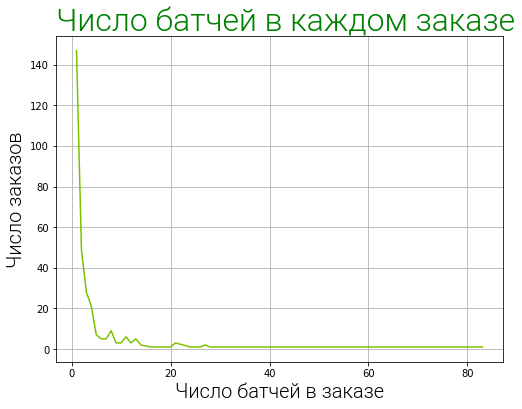

In [ ]:
order_number = plan_df['ORDER'].value_counts()
plt_dist(data=dial_stat, x_label='Число заказов', y_label='Число батчей в заказе', dist_name='Число батчей в каждом заказе')

### Максимальное, минимальное, средние значения батчей в заказах

In [ ]:
men = round(np.mean(order_number), 0)
mx = np.max(order_number)
mn = np.min(order_number)
print(f'Среднее число батчей в заказе: {men}')
print(f'Максимальное число батчей в заказе: {mx}')
print(f'Минимальное число батчей в заказе: {mn}')

Среднее число батчей в заказе: 25.0
Максимальное число батчей в заказе: 343
Минимальное число батчей в заказе: 1


### Количество заказов различных ДСЕ

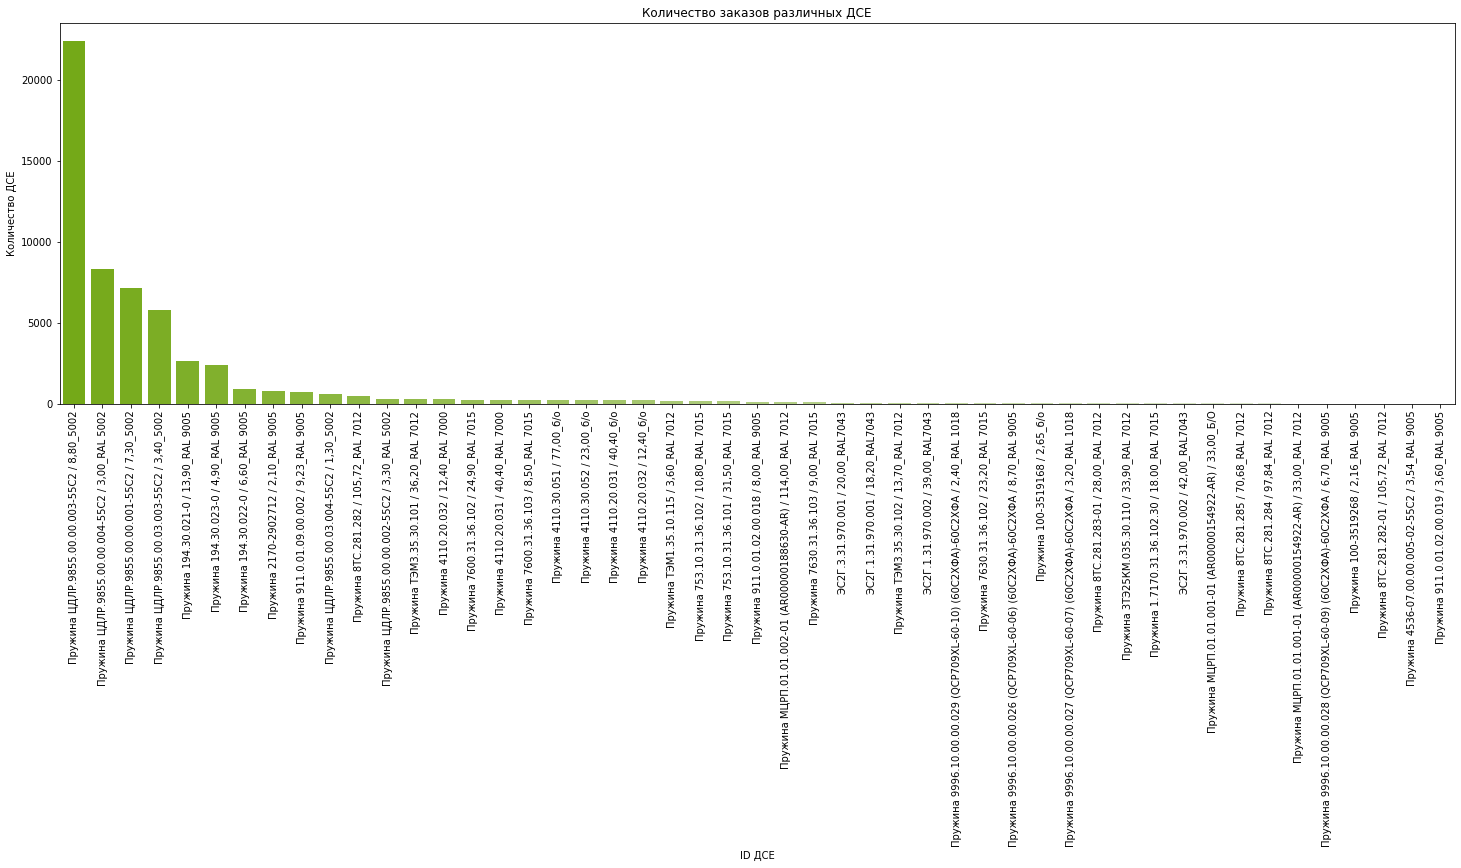

In [ ]:
details_number = plan_df.groupby(['CODE'])['AMOUNT'].agg('sum')
details_number_df = pd.DataFrame({'CODE': list(dict(details_number).keys()), 'AMOUNT': (dict(details_number).values())})
details_number_df = details_number_df.sort_values(by='AMOUNT', ascending=False)

freq_diagram(x='CODE', y='AMOUNT', data_df=details_number_df, x_label='ID ДСЕ', y_label='Количество ДСЕ', bp_name='Количество заказов различных ДСЕ')

In [ ]:
details_number_df_big = details_number_df[details_number_df['AMOUNT']>=300]
details_number_df_small = details_number_df[details_number_df['AMOUNT']<300]

#### Количество заказов различных ДСЕ (популярные ДСЕ)

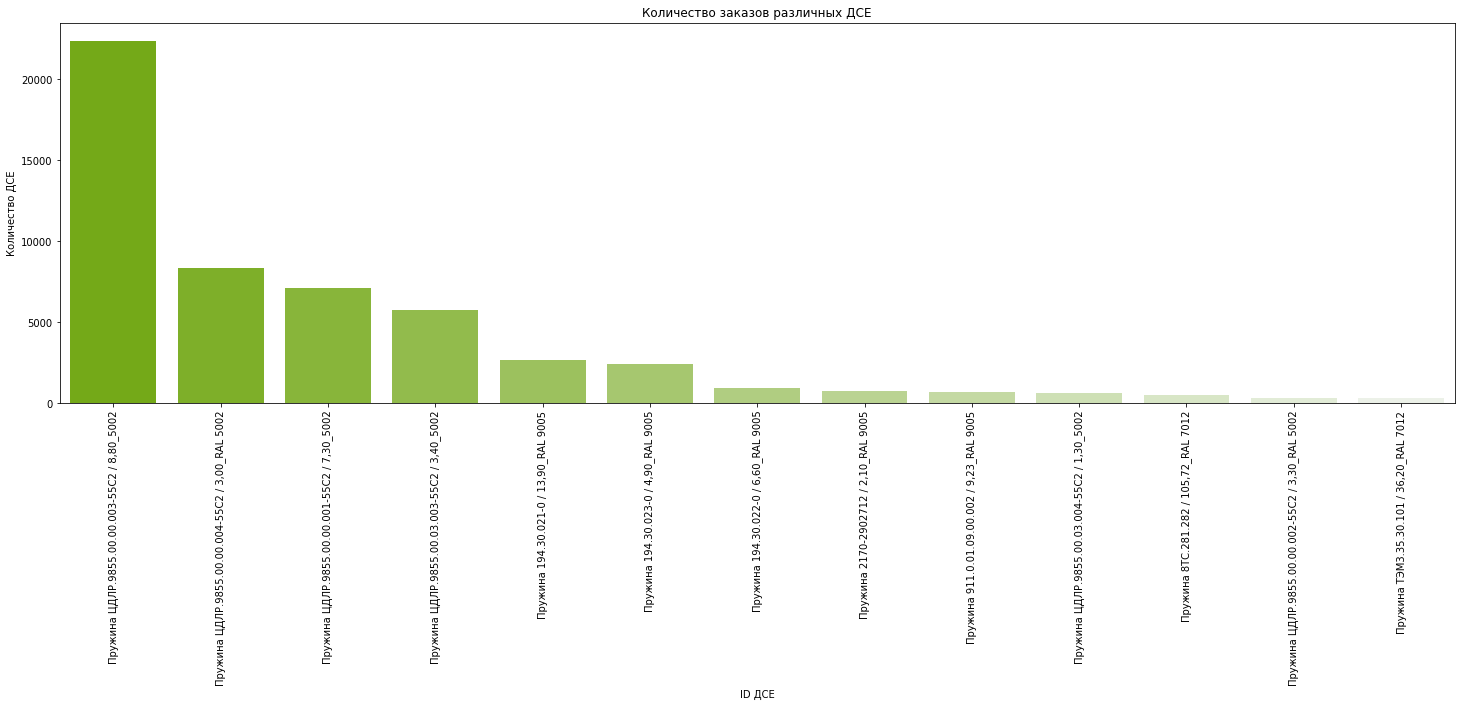

In [ ]:
freq_diagram(x='CODE', y='AMOUNT', data_df=details_number_df_big, x_label='ID ДСЕ', y_label='Количество ДСЕ', bp_name='Количество заказов различных ДСЕ')

#### Количество заказов различных ДСЕ (непопулярные ДСЕ)

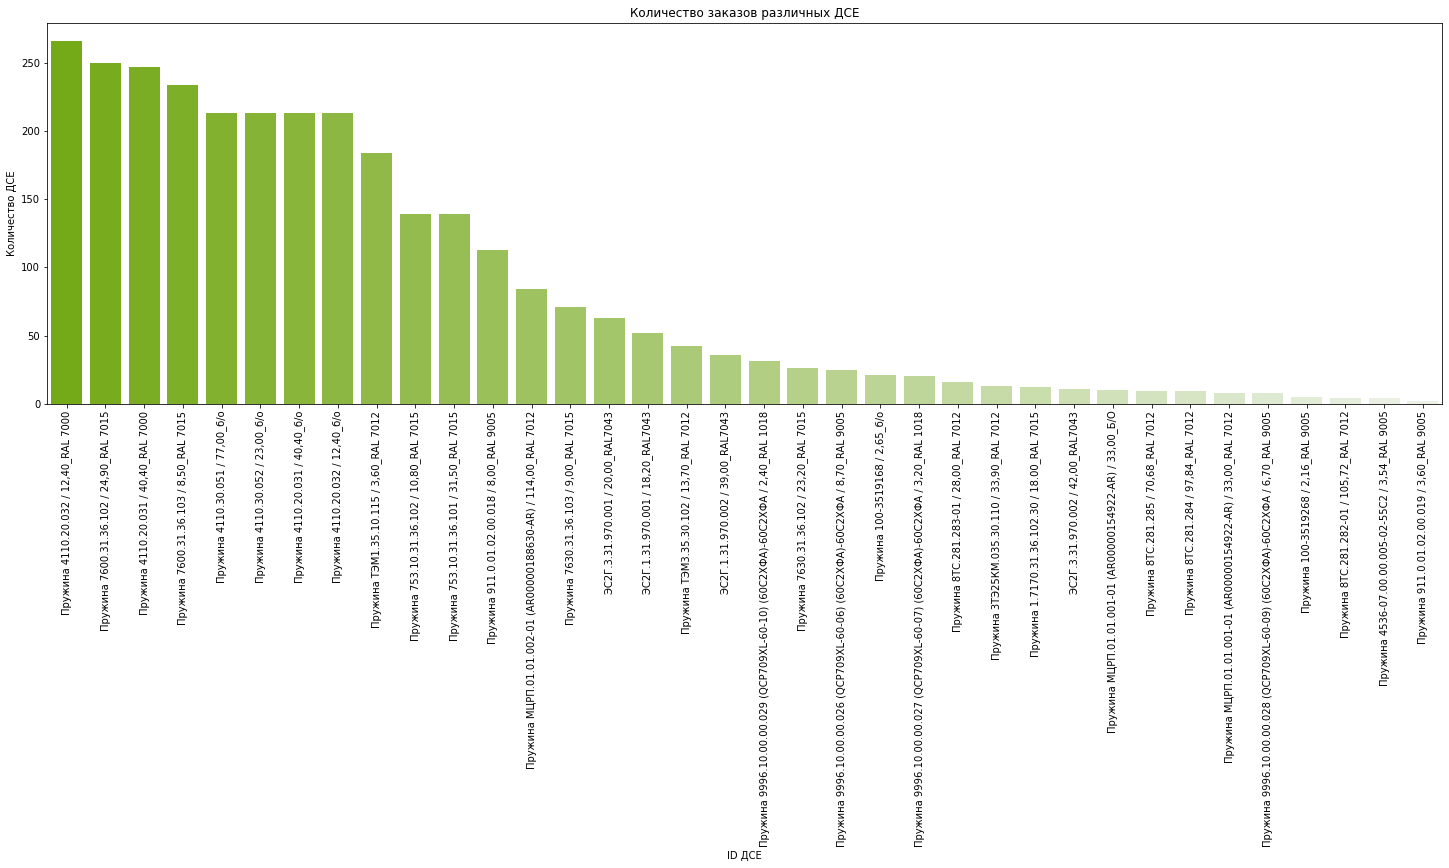

In [ ]:
freq_diagram(x='CODE', y='AMOUNT', data_df=details_number_df_small, x_label='ID ДСЕ', y_label='Количество ДСЕ', bp_name='Количество заказов различных ДСЕ')

## 2. Маршруты ДСЕ 

Оснонвные и альтернативные

In [ ]:
entity_routes_df = pd.read_csv('/drive/My Drive/BFG/entity_route.csv')

In [ ]:
entity_routes_df

,ROUTE_ID,CODE,ALTERNATIVE
0,ДОР-2020.03/9901-410-001,"Пружина 1.7175.31.35.107.00- / 23,60_RAL 9005",0
1,ДОР-2020.03/9901-5923-001,"Пружина 1.7175.31.35.107.00- / 23,60_RAL 9005",1
2,ПРО-2019.07/0204-3111-001,"Пружина 1.7175.31.35.108.00 / 9,90_RAL 7015",0
3,ДОР-2020.03/9901-3111-001,"Пружина 1.7175.31.35.108.00 / 9,90_RAL 7015",1
4,ПРО-2019.02/0202-701-001,"Пружина 7600.31.36.102 / 24,90_RAL 7015",1
...,...,...,...
568,ПРО-2020.05/0201-6102-001,"Пружина 100-3519268-01 / 2,35_RAL 7012",1
569,ПРО-2020.06/0209-6102-001,"Пружина 100-3519268-01 / 2,35_RAL 7012",1
570,ПРО-2020.06/0209-6301-001,"Пружина 100-3519268-01 / 2,35_RAL 7012",0
571,ПРО-2019.04/0206-4101-001,"Пружина 4536-07.00.00.006-02 / 25,00-140,00-24...",0


## 3. Equipment

Есть подразделения оборудования (`DEPT_ID`), в них содержатся классы оборудования (`EQUIPMENT_ID`), в классах оборудования содержатся единицы оборудования (`NAME` или `MODEL`)

In [ ]:
equipment_df = pd.read_csv('/drive/My Drive/BFG/equipment.csv')


In [ ]:
equipment_df

,DEPT_ID,ID,EQUIPMENT_ID,NAME,MODEL
0,Мерная резка и Фаска,101,"Станок мерной резки прутков СП,МСП",Станок мерной резки прутков №1,Станок мерной резки прутков №1
1,Мерная резка и Фаска,102,"Комплекс ручной резки прутков СП,МСП",Комплекс ручной резки прутков №1,Комплекс ручной резки прутков №1
2,Мерная резка и Фаска,103,"Станок мерной резки прутков СП,МСП",Станок мерной резки прутков №2,Станок мерной резки прутков №2
3,Мерная резка и Фаска,105,"Комплекс ручной резки прутков СП,МСП",Комплекс ручной резки прутков №2,Комплекс ручной резки прутков №2
4,Резка тк,106,Отрезной маятниковый станок СОМ 400-Б,Отрезной маятниковый станок СОМ 400-Б,Отрезной маятниковый станок СОМ 400-Б
...,...,...,...,...,...
67,Входной контроль,2401,Участок входного контроля,Участок входного контроля,Участок входного контроля
68,Комплектовка,2801,Принтер трансферной печати Toshiba мод. b-ex4t2,Принтер трансферной печати Toshiba мод. b-ex4t2,Принтер трансферной печати Toshiba мод. b-ex4t2
69,Окончательная приемка,2901,Окончательная приемка,Участок окончательной приемки,Участок окончательной приемки
70,Сбор в комплект,3001,Участок комплектовки,Участок комплектовки,Участок комплектовки


### Количество единиц оборудования в подразделениях оборудования

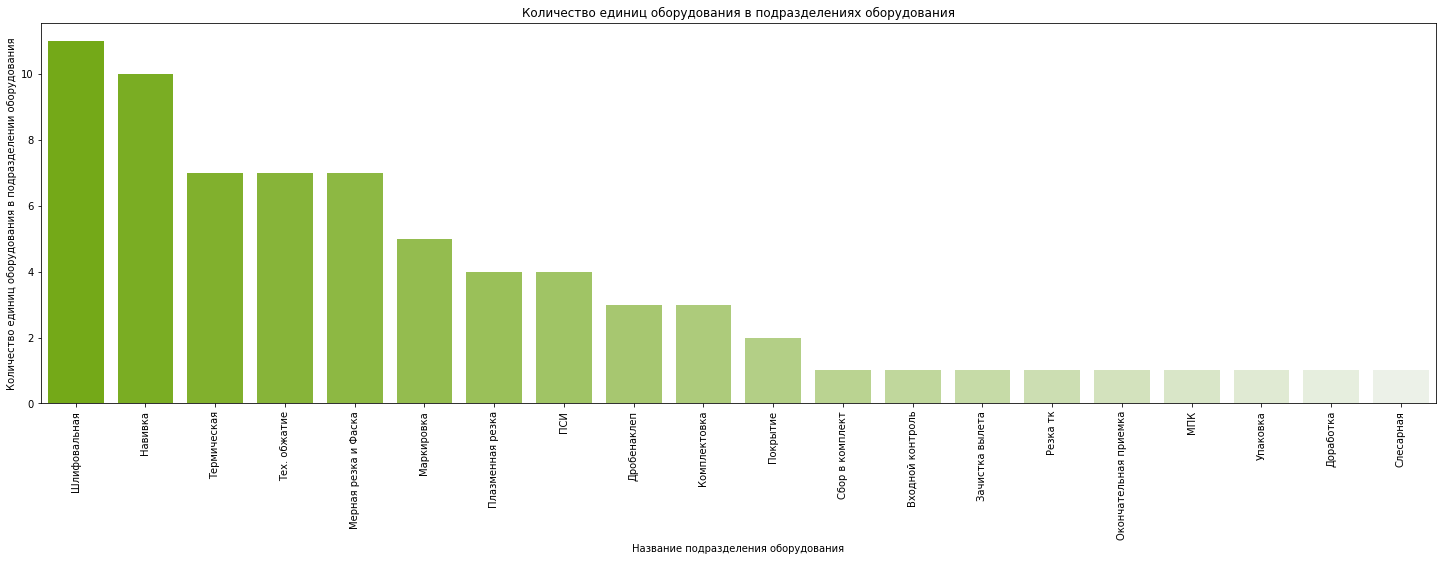

In [ ]:
equipment_number_dept = equipment_df['DEPT_ID'].value_counts()
equipment_number_dept_df = pd.DataFrame({'DEPT_ID': list(dict(equipment_number_dept).keys()), 'AMOUNT': (dict(equipment_number_dept).values())})
equipment_number_dept_df = equipment_number_dept_df.sort_values(by='AMOUNT', ascending=False)


freq_diagram(x='DEPT_ID', y='AMOUNT', data_df=equipment_number_dept_df, x_label='Название подразделения оборудования', 
             y_label='Количество единиц оборудования в подразделении оборудования', bp_name='Количество единиц оборудования в подразделениях оборудования')

### Количество единиц оборудования в классах оборудования

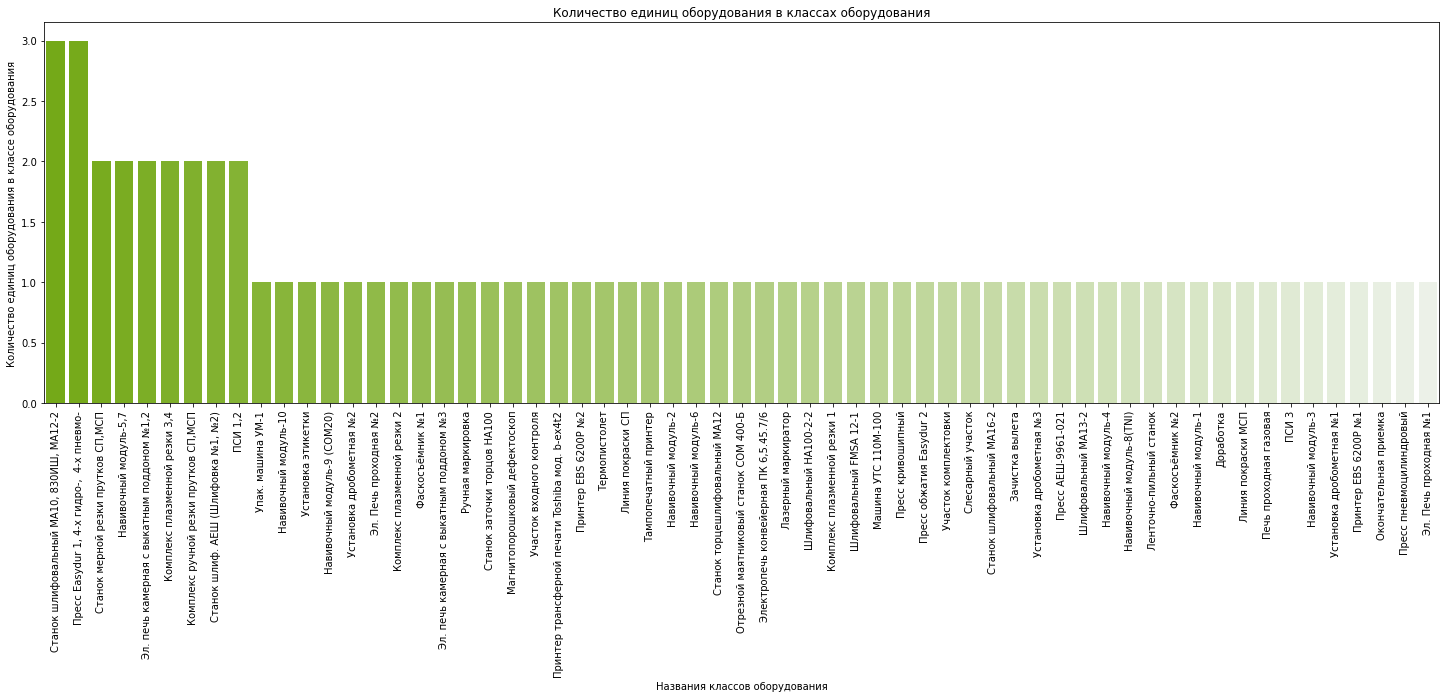

In [ ]:
equipment_number = equipment_df['EQUIPMENT_ID'].value_counts()
equipment_number_df = pd.DataFrame({'EQUIPMENT_ID': list(dict(equipment_number).keys()), 'AMOUNT': (dict(equipment_number).values())})
equipment_number_df = equipment_number_df.sort_values(by='AMOUNT', ascending=False)


freq_diagram(x='EQUIPMENT_ID', y='AMOUNT', data_df=equipment_number_df, x_label='Названия классов оборудования', 
             y_label='Количество единиц оборудования в классе оборудования', bp_name='Количество единиц оборудования в классах оборудования')

## 4. Технологии производства

In [ ]:
technology_nan_df = df_fixes(pd.read_csv('/drive/My Drive/BFG/technology.csv'), 'technology_nan')
technology_df = df_fixes(pd.read_csv('/drive/My Drive/BFG/technology.csv').fillna(0), 'technology')


In [ ]:
technology_nan_df

,ROUTE_ID,NAME,NOP,DEPT_ID,EQUIPMENT_ID,T_NAL,T_PZ,T_SHT,OPERATION_ID,CODE
0,ПРО-2020.06/0210-501-011,Навивка,1,Навивка,Навивочный модуль-10,NaN,NaN,NaN,2423_02,"Пружина 194.30.021-0 / 13,90_RAL 9005"
1,ПРО-2020.06/0210-501-011,Термическая,2,Термическая,Эл. Печь проходная №1,NaN,NaN,NaN,2423_05,"Пружина 194.30.021-0 / 13,90_RAL 9005"
2,ПРО-2020.06/0210-501-011,Плазменная резка,3,Плазменная резка,Комплекс плазменной резки 2,NaN,NaN,NaN,2423_04,"Пружина 194.30.021-0 / 13,90_RAL 9005"
3,ПРО-2020.06/0210-501-011,Зачистка вылета,4,Зачистка вылета,Зачистка вылета,NaN,NaN,NaN,2423_20,"Пружина 194.30.021-0 / 13,90_RAL 9005"
4,ПРО-2020.06/0210-501-011,Дробенаклеп,5,Дробенаклеп,Установка дробометная №1,NaN,NaN,NaN,2423_09,"Пружина 194.30.021-0 / 13,90_RAL 9005"
...,...,...,...,...,...,...,...,...,...,...
4844,ДОР-2019.02/9901-101-001,Дошлифовка,1,Шлифовальная,"Станок шлиф. АЕШ (Шлифовка №1, №2)",60.0,NaN,6.000000,1833_14,"Пружина 4536-07.00.00.006-02-55C2 / 9,73_RAL 9005"
4845,ДОР-2019.02/9901-101-001,Дробенаклеп,2,Дробенаклеп,Установка дробометная №3,NaN,NaN,0.250000,1833_09,"Пружина 4536-07.00.00.006-02-55C2 / 9,73_RAL 9005"
4846,ДОР-2019.02/9901-101-001,Тех. обжатие,3,Тех. обжатие,"Пресс Easydur 1, 4-х гидро-, 4-х пневмо-",NaN,NaN,0.500000,1833_06,"Пружина 4536-07.00.00.006-02-55C2 / 9,73_RAL 9005"
4847,ДОР-2019.02/9901-101-001,ПСИ,4,ПСИ,"ПСИ 1,2",NaN,NaN,0.183333,1833_08,"Пружина 4536-07.00.00.006-02-55C2 / 9,73_RAL 9005"


In [ ]:
technology_nan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4849 entries, 0 to 4848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ROUTE_ID      4849 non-null   object 
 1   NAME          4849 non-null   object 
 2   NOP           4849 non-null   int64  
 3   DEPT_ID       4849 non-null   object 
 4   EQUIPMENT_ID  4849 non-null   object 
 5   T_NAL         770 non-null    float64
 6   T_PZ          9 non-null      float64
 7   T_SHT         4341 non-null   float64
 8   OPERATION_ID  4849 non-null   object 
 9   CODE          4849 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 379.0+ KB


In [ ]:
technology_nan_df.isnull().sum()

ROUTE_ID           0
NAME               0
NOP                0
DEPT_ID            0
EQUIPMENT_ID       0
T_NAL           4079
T_PZ            4840
T_SHT            508
OPERATION_ID       0
CODE               0
dtype: int64

### Число маршрутов в операциях

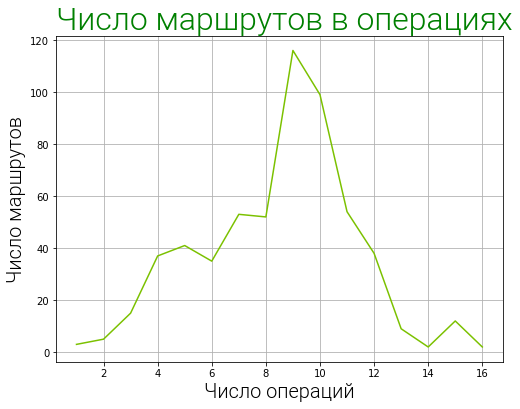

In [ ]:
route_number = technology_df['ROUTE_ID'].value_counts()
dial_stat = Counter(list(route_number))
plt_dist(data=dial_stat, x_label='Число маршрутов', y_label='Число операций', dist_name='Число маршрутов в операциях')

### Объемы использования (в шт ДСЕ) оборудования разных классов

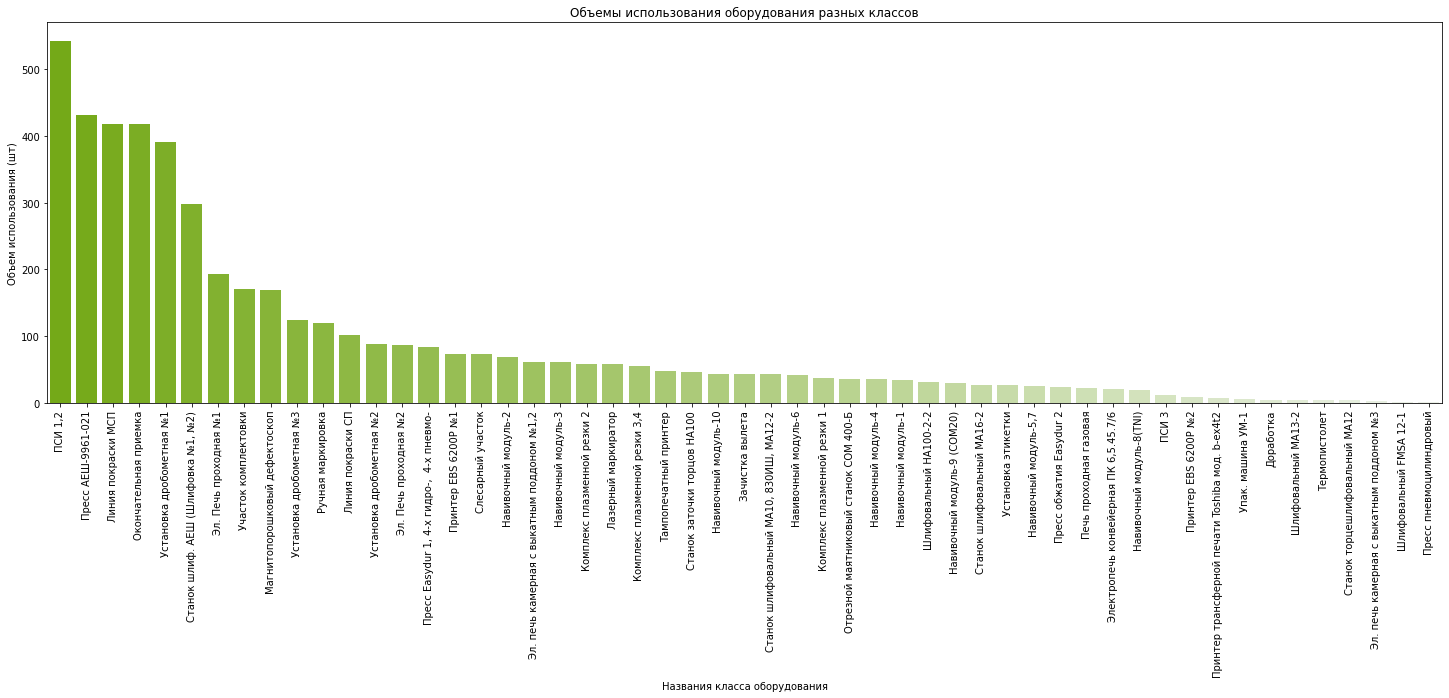

In [ ]:
equipment_amount = technology_df['EQUIPMENT_ID'].value_counts()
equipment_amount_df = pd.DataFrame(equipment_amount)
equipment_amount_df['AMOUNT'] = list(equipment_amount_df['EQUIPMENT_ID'])
equipment_amount_df['EQUIPMENT_ID'] = list(equipment_amount_df.index)
equipment_amount_df = equipment_amount_df.sort_values(by='AMOUNT', ascending=False)

freq_diagram(x='EQUIPMENT_ID', y='AMOUNT', data_df=equipment_amount_df, x_label='Названия класса оборудования', 
             y_label='Объем использования (шт)', bp_name='Объемы использования оборудования разных классов')

### Максимальное, минимальное, среднее значения времени на производство одной детали

In [ ]:
technology_t_sht_df = technology_df[technology_df['T_SHT']>0]
men = round(np.mean(list(technology_t_sht_df['T_SHT'])), 0)
mx = np.max(list(technology_t_sht_df['T_SHT']))
mn = np.min(list(technology_t_sht_df['T_SHT']))
print(f'Среднее время на производство одной детали (мин): {men}')
print(f'Максимальное время на производство одной детали (мин): {mx}')
print(f'Минимальное время на производство одной детали (мин): {mn}')

Среднее время на производство одной детали (мин): 3.0
Максимальное время на производство одной детали (мин): 60.0
Минимальное время на производство одной детали (мин): 0.016666


### Суммарное время работ по топ-50 самых длинных маршрутов  

На одну шт ДСЕ 

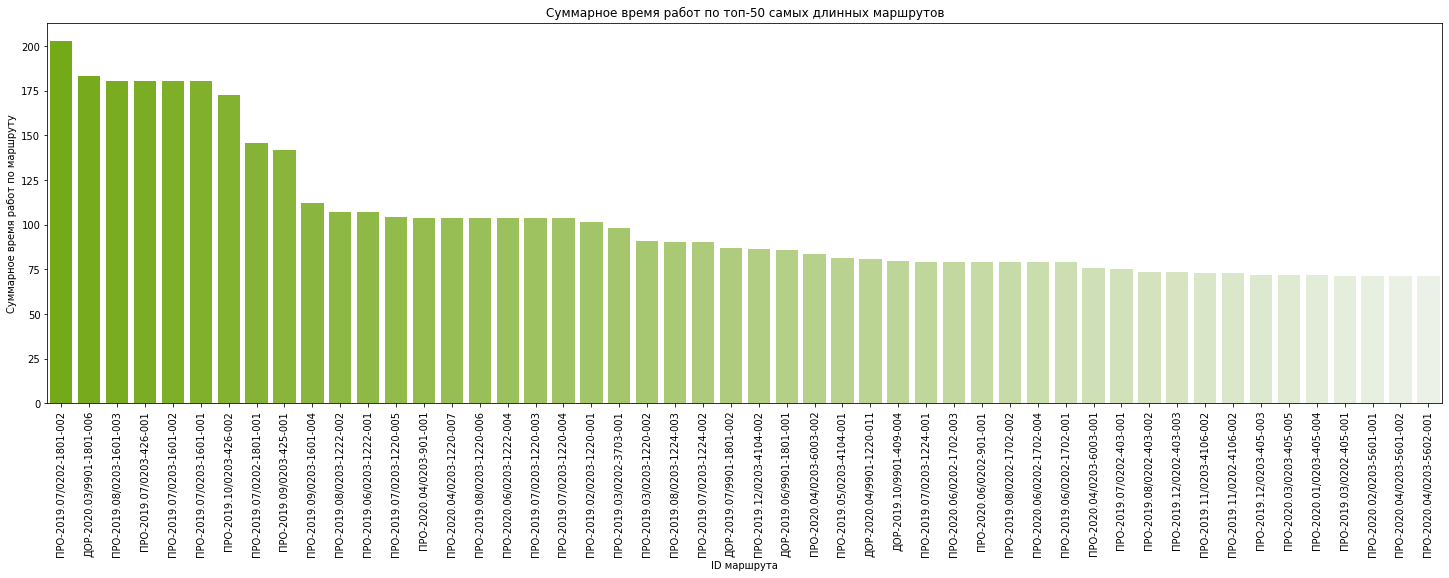

In [ ]:
route_time_df = technology_df.groupby(['ROUTE_ID'])['T_SHT'].agg('sum')
route_time_df = pd.DataFrame({'ROUTE_ID': list(dict(route_time_df).keys()), 'T_SHT': (dict(route_time_df).values())})
route_time_df = route_time_df.sort_values(by='T_SHT', ascending=False)
route_time_df = route_time_df.iloc[:50]

freq_diagram(x='ROUTE_ID', y='T_SHT', data_df=route_time_df, x_label='ID маршрута', 
             y_label='Суммарное время работ по маршруту', bp_name='Суммарное время работ по топ-50 самых длинных маршрутов')

## 5. Состояние производства (NZP)

In [ ]:
nzp_df = df_fixes(pd.read_csv('/drive/My Drive/BFG/NZP.csv'), 'NZP')


In [ ]:
nzp_df[nzp_df['OPERATION_PROGRESS']>0]

,ORDER,BATCH_ID,CODE,AMOUNT,OPERATION_ID,OPERATION_PROGRESS


In [ ]:
nzp_df

,ORDER,BATCH_ID,CODE,AMOUNT,OPERATION_ID,OPERATION_PROGRESS
0,20-000043,10227931,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2300_04,0
1,20-000043,10227938,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2281_04,0
2,20-000043,10227941,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2300_04,0
3,20-000043,10227942,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2281_04,0
4,20-000043,10227948,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2300_04,0
...,...,...,...,...,...,...
1490,17-000010,10219004,"Пружина 911.0.01.09.00.002 / 9,23_RAL 9005",2,2200_10,0
1491,16-000051,10219164,"Пружина ТЭМ3.35.30.102 / 13,70_RAL 7012",5,2197_29,0
1492,16-000050,10219077,"ЭС2Г.1.31.970.001 / 18,20_RAL7043",2,2022_29,0
1493,NaN,10140839,Пружина МЦРП.01.01.001-01 (AR00000154922-AR) /...,6,1055_11,0


### Объем работы на операциях

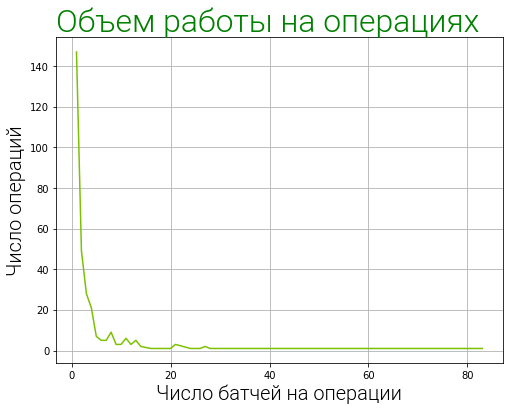

In [ ]:
order_number = nzp_df['OPERATION_ID'].value_counts()
dial_stat = Counter(list(order_number))
plt_dist(data=dial_stat, x_label='Число операций', y_label='Число батчей на операции', dist_name='Объем работы на операциях')

### Проверка гипотезы о том, что любая комбинация "CODE"+"OPERATION_ID" соответствуют только одной записи из таблицы technology.csv

- для каждой детали есть несколько маршрутов
- для каждого маршрута описана последовательность операций 
- для каждой детали из nzp есть operation id на которой остановилось производство

**Вопрос**: можно ли однозначно определить, на каком маршруте и на каком шаге маршрута сейчас находится батч в NZP по комбинации "CODE"+"OPERATION_ID"?

In [ ]:
plan_cases_df = technology_df.groupby(['CODE', 'OPERATION_ID'],as_index = False).count()[['CODE', 'OPERATION_ID', 'NAME']]#.pivot('ROUTE_ID','CODE').fillna(0)['NAME']
plan_cases_df['AMOUNT'] = plan_cases_df['NAME']
del plan_cases_df['NAME']

#### Неоднозначные пары значений "CODE"+"OPERATION_ID

In [ ]:
controversial_plan_cases_df = plan_cases_df[plan_cases_df['AMOUNT']>1]
print(f'Неоднозначных значений "CODE"+"OPERATION_ID": {controversial_plan_cases_df.shape[0]}')
controversial_plan_cases_df

Неоднозначных значений "CODE"+"OPERATION_ID": 22


,CODE,OPERATION_ID,AMOUNT
837,"Пружина 2FWG696.0.02.023.001 / 7,90_RAL 9005",1867_06,2
844,"Пружина 2FWG696.0.02.023.002 / 17,70_RAL 9005",1868_06,2
851,"Пружина 3FWG106.0.04.012.002 / 1,90_RAL 9005",1866_06,2
2516,"Пружина 98 120 597 80 / 2,47_RAL 9005",1847_06,2
2517,"Пружина 98 120 597 80 / 2,47_RAL 9005",1847_08,2
2518,"Пружина 98 120 597 80 / 2,47_RAL 9005",1847_09,2
2526,"Пружина 98 120 597 80 / 2,47_RAL 9005",1862_06,2
2527,"Пружина 98 120 597 80 / 2,47_RAL 9005",1862_08,2
2547,"Пружина 98 120 607 80 / 1,78_RAL 9005",1864_06,2
2548,"Пружина 98 120 607 80 / 1,78_RAL 9005",1864_08,2


#### Пример неоднозначной пары значений "CODE"+"OPERATION_ID"

In [ ]:
example_df = technology_df[(technology_df['CODE']=='Пружина НПЦ v7.4_r / 7,80_RAL 9005') & (technology_df['OPERATION_ID']=='1869_06')]
example_df

,ROUTE_ID,NAME,NOP,DEPT_ID,EQUIPMENT_ID,T_NAL,T_PZ,T_SHT,OPERATION_ID,CODE
3508,ПРО-2019.03/0201-1805-001,Тех. обжатие,6,Тех. обжатие,Пресс АЕШ-9961-021,0.0,0.0,0.8,1869_06,"Пружина НПЦ v7.4_r / 7,80_RAL 9005"
3511,ПРО-2019.03/0201-1805-001,Тех. обжатие,9,Тех. обжатие,Пресс АЕШ-9961-021,0.0,0.0,0.8,1869_06,"Пружина НПЦ v7.4_r / 7,80_RAL 9005"


#### Проверка NZP.csv на наличие проблемных пар "CODE"+"OPERATION_ID"

In [ ]:
errors_nzp_df = pd.merge(controversial_plan_cases_df, nzp_df, how='left', on=['OPERATION_ID', 'CODE']).fillna('not in NZP')
errors_nzp_df = errors_nzp_df[errors_nzp_df['ORDER']!='not in NZP']
print(f'Число проблемных пар значений "CODE"+"OPERATION_ID" в NZP.csv: {errors_nzp_df.shape[0]}')

Число проблемных пар значений "CODE"+"OPERATION_ID" в NZP.csv: 0


In [ ]:
errors_nzp_df

,CODE,OPERATION_ID,AMOUNT_x,ORDER,BATCH_ID,AMOUNT_y,OPERATION_PROGRESS


**Результат**: Связка "CODE"+"OPERATION_ID" (где "CODE" это id ДСЕ) не однозначно определяется в таблице `technology.csv` в 22 случаях. То есть, если какие-то из этих 22 случаев присутствуют в `NZP.csv`, то для них нельзя будет однозначно понять, на какой из стадий (NOP) в данный момент находится батч. 

Но в данном файле `NZP.csv` нет этих проблемных связок, поэтому в данном случае можно однозначно определить и маршрут, и шаг маршрута (NOP) для каждой связки "CODE"+"OPERATION_ID". 

Но эта проблема может быть актуальна в будущем, если в NZP появятся проблематичные "CODE"+"OPERATION_ID". 

Примеры проблемных связок представлены в таблице `controversial_plan_cases_df` выше. 

**Например**, если у нас в NZP есть связка "Пружина НПЦ v7.4_r / 7,80_RAL 9005" + "1869_06", мы не можем сопоставить ее 1-к-1му с конкретным шагом ("NOP") маршрута "ПРО-2019.03/0204-3206-001", тк это может быть 6й или 9й шаг этого маршрута (см колонку "NOP")". (См. таблицу `example_df` выше)

Решение проблемы: необходимо либо следить за тем, чтобы не было таких "проблемных" связок "CODE"+"OPERATION_ID", либо указывать значения "NOP" в таблице `NZP.csv`


### Слияние таблицы nzp_df с таблицей technology_df по связке "CODE"+"OPERATION_ID" 1-к-1му

Чтобы узнать, на каком маршруте и шаге маршрута каждый батч в NZP сейчас находится


In [ ]:
nzp_df_full = pd.merge(nzp_df, technology_df, how='left', on=['OPERATION_ID', 'CODE']).fillna('not in technology_df')

#### Есть ли такие батчи в NZP, для пары "CODE"+"OPERATION_ID" которых нет соответствий в technology_df?

In [ ]:
errors_df = nzp_df_full[nzp_df_full['ROUTE_ID']=='not in technology_df']
print('Количество батчей в NZP, для пары "CODE"+"OPERATION_ID" которых нет соответствий в technology_df:', errors_df.shape[0])

Количество батчей в NZP, для пары "CODE"+"OPERATION_ID" которых нет соответствий в technology_df: 20


In [ ]:
nzp_df_full = pd.merge(nzp_df_full, entity_routes_df, how='left', on=['ROUTE_ID', 'CODE']).fillna('not in entity_routes_df')

### Какие батчи (и сколько деталей) еще не проходят ни по одному из маршрутов

In [ ]:
nzp_plan_merge_df = pd.merge(plan_df, nzp_df_full, how='left', on=['ORDER', 'CODE', 'AMOUNT']).fillna('not in nzp')
nzp_plan_not_in_nzp_df = nzp_plan_merge_df[nzp_plan_merge_df['BATCH_ID']=='not in nzp']
sum_not_started_details = sum(list(nzp_plan_not_in_nzp_df['INITIAL_AMOUNT']))
sum_details = sum(list(plan_df['INITIAL_AMOUNT']))
part_not_started_details = sum_not_started_details/sum_details
print(f'Количество батчей, которые не проходят ни по одному маршруту: {nzp_plan_not_in_nzp_df.shape[0]} из {plan_df.shape[0]} всех батчей')
print(f"% батчей, которые не проходят ни по одному маршруту: {nzp_plan_not_in_nzp_df.shape[0]/plan_df.shape[0]}\n")
print(f"Количество батчей на 1м шаге определенного маршрута (0% выполнено): {nzp_df_full[nzp_df_full['NOP']==1].shape[0]}\n")

print(f"Количество ДСЕ, которые не проходят ни по одному маршруту: {sum_not_started_details} из {sum_details} всех деталей")
print(f"% ДСЕ, которые не проходят ни по одному маршруту: {round(part_not_started_details, 2)}\n\n")

nzp_plan_not_in_nzp_df.head()

Количество батчей, которые не проходят ни по одному маршруту: 30 из 1505 всех батчей
% батчей, которые не проходят ни по одному маршруту: 0.019933554817275746

Количество батчей на 1м шаге определенного маршрута (0% выполнено): 2

Количество ДСЕ, которые не проходят ни по одному маршруту: 164515 из 201968 всех деталей
% ДСЕ, которые не проходят ни по одному маршруту: 0.81




,INITIAL_AMOUNT,AMOUNT,DATE,ORDER,CODE,NAME_x,#IDENTITY,BATCH_ID,OPERATION_ID,OPERATION_PROGRESS,ROUTE_ID,NAME_y,NOP,DEPT_ID,EQUIPMENT_ID,T_NAL,T_PZ,T_SHT,ALTERNATIVE
0,6660,0,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.03.003-55С2 / 3,40_5002","Пружина ЦДЛР.9855.00.03.003-55С2 / 3,40_5002",43010000000000000193_НА-000213515_2098,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp
1,6500,0,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.03.004-55С2 / 1,30_5002","Пружина ЦДЛР.9855.00.03.004-55С2 / 1,30_5002",43010000000000000194_НА-000214681_2209,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp
2,14920,1275,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002","Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",43010000000000000189_НА-000213512_2302,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp
3,60404,14928,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.00.003-55С2 / 8,80_5002","Пружина ЦДЛР.9855.00.00.003-55С2 / 8,80_5002",43010000000000000191_НА-000213518_2081,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp
4,3250,70,2020-06-01 8:00:00,NOT_STARTED_1,"Пружина ЦДЛР.9855.00.00.004-55С2 / 3,00_RAL 5002","Пружина ЦДЛР.9855.00.00.004-55С2 / 3,00_RAL 5002",43010000000000000192_НА-000108291_2314,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp,not in nzp


## 6. NZP, самая полная таблица 

Слияние всех полезных данных в одной таблице

In [ ]:
nzp_df_full

,ORDER,BATCH_ID,CODE,AMOUNT,OPERATION_ID,OPERATION_PROGRESS,ROUTE_ID,NAME,NOP,DEPT_ID,EQUIPMENT_ID,T_NAL,T_PZ,T_SHT,ALTERNATIVE
0,20-000043,10227931,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2300_04,0,ПРО-2020.01/0206-1205-009,Плазменная резка,3,Плазменная резка,"Комплекс плазменной резки 3,4",0,0,0.8,1
1,20-000043,10227938,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2281_04,0,ПРО-2020.01/0204-1205-005,Плазменная резка,3,Плазменная резка,"Комплекс плазменной резки 3,4",0,0,0.8,1
2,20-000043,10227941,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2300_04,0,ПРО-2020.01/0206-1205-009,Плазменная резка,3,Плазменная резка,"Комплекс плазменной резки 3,4",0,0,0.8,1
3,20-000043,10227942,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2281_04,0,ПРО-2020.01/0204-1205-005,Плазменная резка,3,Плазменная резка,"Комплекс плазменной резки 3,4",0,0,0.8,1
4,20-000043,10227948,"Пружина ЦДЛР.9855.00.00.001-55С2 / 7,30_5002",60,2300_04,0,ПРО-2020.01/0206-1205-009,Плазменная резка,3,Плазменная резка,"Комплекс плазменной резки 3,4",0,0,0.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,17-000010,10219004,"Пружина 911.0.01.09.00.002 / 9,23_RAL 9005",2,2200_10,0,ДОР-2019.12/9901-908-002,Покрытие,5,Покрытие,Линия покраски МСП,0,0,0.833333,1
1491,16-000051,10219164,"Пружина ТЭМ3.35.30.102 / 13,70_RAL 7012",5,2197_29,0,ДОР-2019.12/9901-406-002,Окончательная приемка,11,Окончательная приемка,Окончательная приемка,0,0,0.016666,1
1492,16-000050,10219077,"ЭС2Г.1.31.970.001 / 18,20_RAL7043",2,2022_29,0,ДОР-2019.08/9901-404-002,Окончательная приемка,7,Окончательная приемка,Окончательная приемка,0,0,0.016666,1
1493,not in technology_df,10140839,Пружина МЦРП.01.01.001-01 (AR00000154922-AR) /...,6,1055_11,0,not in technology_df,not in technology_df,not in technology_df,not in technology_df,not in technology_df,not in technology_df,not in technology_df,not in technology_df,not in entity_routes_df


In [ ]:
nzp_df_steps = pd.merge(nzp_df_full, technology_df, how='left', on=['ROUTE_ID']).fillna('-')

In [ ]:
new_indexes = []
nop_NZP_list = list(nzp_df_steps['NOP_x'])
nop_all_list = list(nzp_df_steps['NOP_y'])
for i in range(len(nop_NZP_list)):
  if nop_NZP_list[i]<=nop_all_list[i]:
    new_indexes.append(i)

nzp_df_steps = nzp_df_steps.iloc[new_indexes]

In [ ]:
batch_time_list = [amount*time_sht for amount, time_sht in zip(list(nzp_df_steps['AMOUNT']), list(nzp_df_steps['T_SHT_y']))]
nzp_df_steps['BATCH_TIME'] = batch_time_list

### Сводная таблица затраченного времени на работы над батчами на оборудовании определенных классов

In [ ]:
nzp_df_steps_group_1 = nzp_df_steps.groupby(['BATCH_ID', 'EQUIPMENT_ID_y'],as_index = False).agg({"BATCH_TIME": "sum"}).pivot('BATCH_ID', 'EQUIPMENT_ID_y').fillna(0)
nzp_df_steps_group_1.head(10)

BATCH_TIME  ...                                           
EQUIPMENT_ID_y Зачистка вылета  ... Эл. печь камерная с выкатным поддоном №1,2
BATCH_ID                        ...                                           
10179942                   0.0  ...                                        0.0
10179943                   0.0  ...                                        0.0
10179944                   0.0  ...                                        0.0
10180059                   0.0  ...                                        0.0
10181622                   0.0  ...                                        0.0
10184463                   0.0  ...                                       10.0
10184532                   0.0  ...                                       10.0
10185791                   0.0  ...                                        0.0
10185813                   0.0  ...                                        0.0
10186536                   0.0  ...                                        0.0

[10 rows x 35 columns]

### Сводная таблица затраченного времени на работу над ДСЕ определенного типа на оборудовании определенных классов

In [ ]:
nzp_df_steps_group_2 = nzp_df_steps.groupby(['CODE_y', 'EQUIPMENT_ID_y'],as_index = False).agg({"BATCH_TIME": "sum"}).pivot('CODE_y', 'EQUIPMENT_ID_y').fillna(0)
nzp_df_steps_group_2.head(10)

BATCH_TIME  ...                                           
EQUIPMENT_ID_y                               Зачистка вылета  ... Эл. печь камерная с выкатным поддоном №1,2
CODE_y                                                        ...                                           
Пружина 1.7170.31.36.102.30 / 18.00_RAL 7015             0.0  ...                                        0.0
Пружина 100-3519168 / 2,65_б/о                           0.0  ...                                        0.0
Пружина 100-3519268 / 2,16_RAL 9005                      0.0  ...                                        0.0
Пружина 194.30.021-0 / 13,90_RAL 9005                    0.4  ...                                        0.0
Пружина 194.30.022-0 / 6,60_RAL 9005                     0.0  ...                                        0.0
Пружина 194.30.023-0 / 4,90_RAL 9005                     5.0  ...                                        0.0
Пружина 2170-2902712 / 2,10_RAL 9005                     0.0  ...                                        0.0
Пружина 3ТЭ25КМ.035.30.110 / 33,90_RAL 7012              0.0  ...                                        0.0
Пружина 4110.20.031 / 40,40_RAL 7000                     0.0  ...                                        0.0
Пружина 4110.20.031 / 40,40_б/о                          0.0  ...                                        0.0

[10 rows x 35 columns]

### Суммарное время изготовления ДСЕ разного типа (мин)

Для выполнения плана `plan_new.csv` (не считая батчей, для которых еще не определены маршруты)

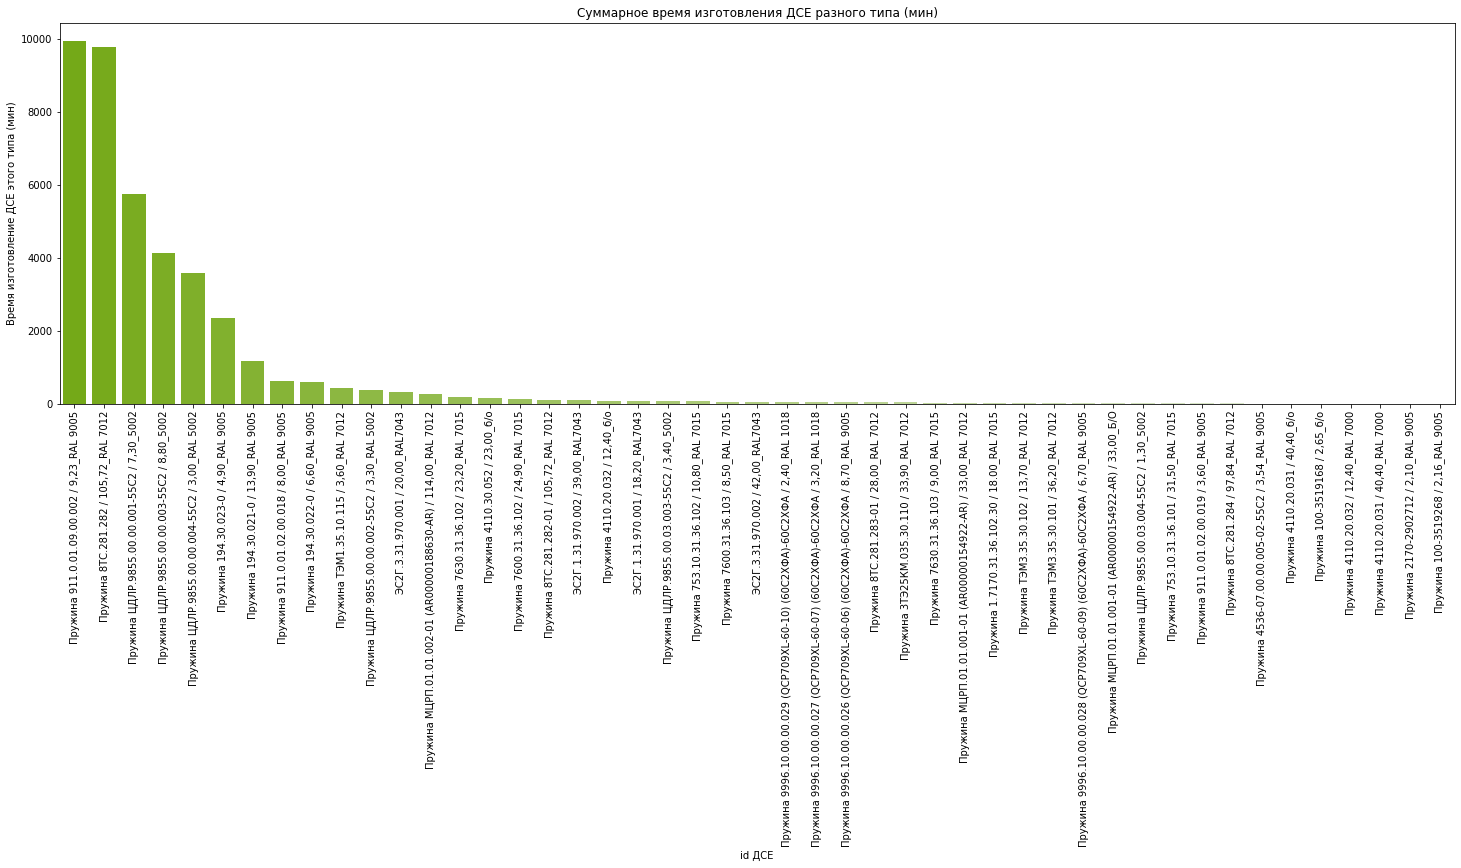

In [ ]:
details_time_number = nzp_df_steps.groupby(['CODE_y'])['BATCH_TIME'].agg('sum')
details_time_number_df = pd.DataFrame({'CODE_y': list(dict(details_time_number).keys()), 'BATCH_TIME': (dict(details_time_number).values())})
details_time_number_df = details_time_number_df.sort_values(by='BATCH_TIME', ascending=False)

freq_diagram(x='CODE_y', y='BATCH_TIME', data_df=details_time_number_df, x_label='id ДСЕ', 
             y_label='Время изготовление ДСЕ этого типа (мин)', bp_name='Суммарное время изготовления ДСЕ разного типа (мин)')

### Суммарное время использования оборудования разных классов (мин)

Для выполнения плана `plan_new.csv` (не считая батчей, для которых еще не определены маршруты)

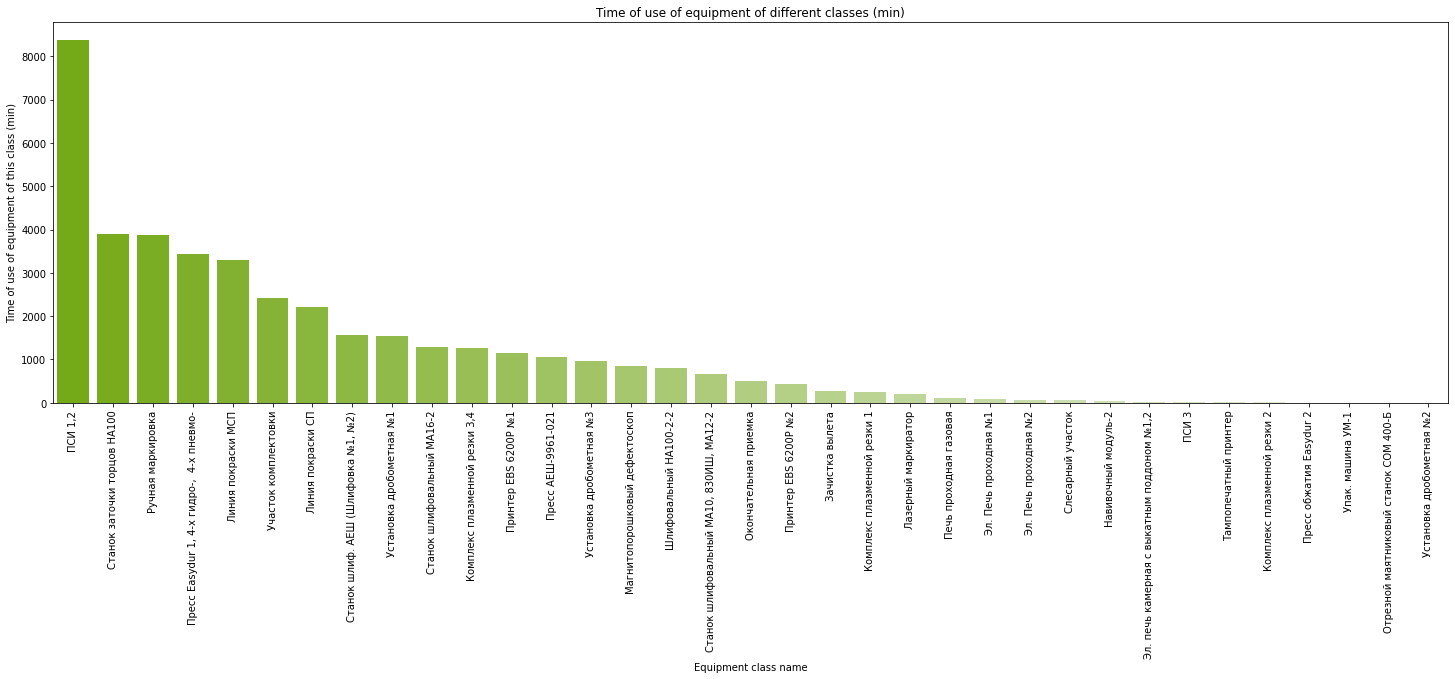

In [ ]:
equipment_time_number = nzp_df_steps.groupby(['EQUIPMENT_ID_y'])['BATCH_TIME'].agg('sum')
equipment_time_number_df = pd.DataFrame({'EQUIPMENT_ID_y': list(dict(equipment_time_number).keys()), 'BATCH_TIME': (dict(equipment_time_number).values())})
equipment_time_number_df = equipment_time_number_df.sort_values(by='BATCH_TIME', ascending=False)

freq_diagram(x='EQUIPMENT_ID_y', y='BATCH_TIME', data_df=equipment_time_number_df, x_label='Equipment class name', 
             y_label='Time of use of equipment of this class (min)', bp_name='Time of use of equipment of different classes (min)')

### Оставшееся время использования оборудования разных классов (мин) на один батч (пример)
Текст по оси x обозначает название класса оборудования и NOP, разделенные символом «___».


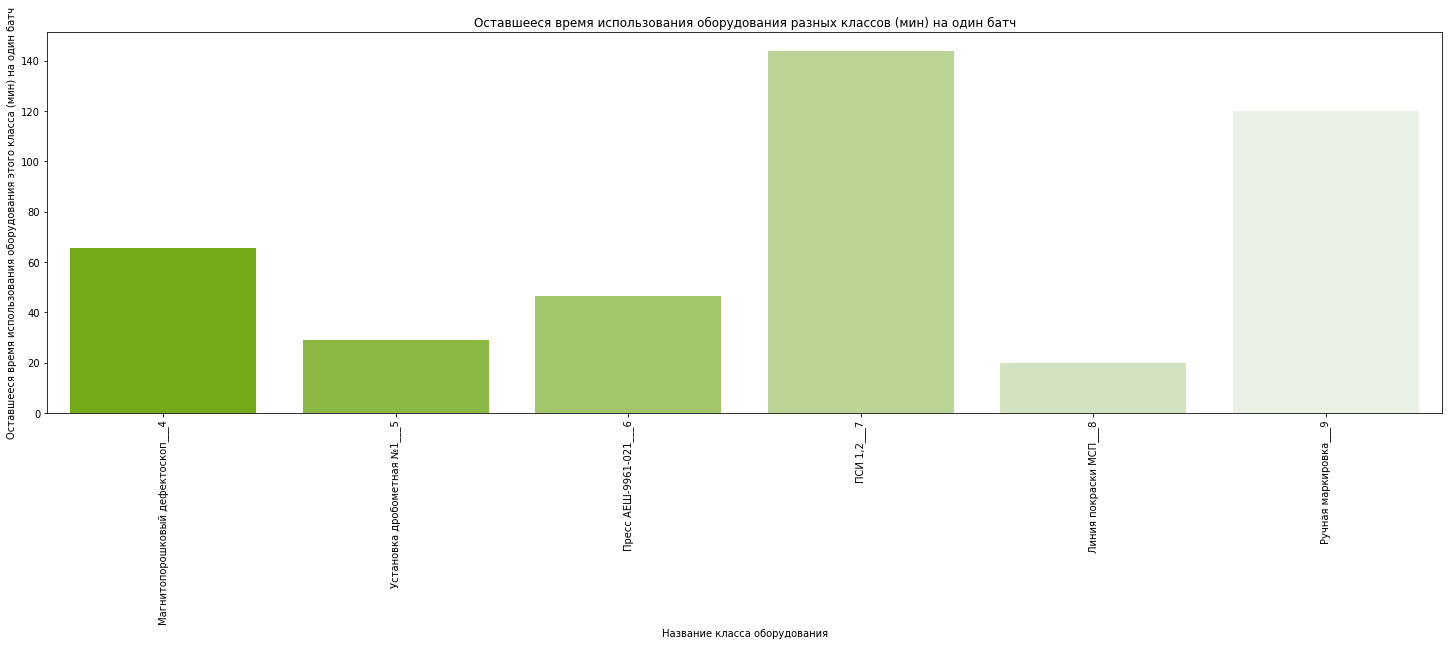

In [ ]:
nzp_df_steps_example = nzp_df_steps[(nzp_df_steps['CODE_y']=='Пружина 911.0.01.09.00.002 / 9,23_RAL 9005') & (nzp_df_steps['BATCH_ID']==10227915)]
nzp_df_steps_example['EQUIPMENT_ID_NOP'] = [str(eq_id)+'___'+str(int(nop)) for eq_id, nop in zip(list(nzp_df_steps_example['EQUIPMENT_ID_y']), list(nzp_df_steps_example['NOP_y']))]
equipment_time_ex_number = nzp_df_steps_example.groupby(['EQUIPMENT_ID_NOP'])['BATCH_TIME'].agg('sum')
equipment_time_ex_number_df = pd.DataFrame({'EQUIPMENT_ID_NOP': list(dict(equipment_time_ex_number).keys()), 'BATCH_TIME': (dict(equipment_time_ex_number).values())})
equipment_time_ex_number_df['NOP'] = [eq_nop.split('___')[-1] for eq_nop in list(equipment_time_ex_number_df['EQUIPMENT_ID_NOP'])]
equipment_time_ex_number_df = equipment_time_ex_number_df.sort_values(by='NOP', ascending=True)

freq_diagram(x='EQUIPMENT_ID_NOP', y='BATCH_TIME', data_df=equipment_time_ex_number_df, x_label='Название класса оборудования', 
             y_label='Оставшееся время использования оборудования этого класса (мин) на один батч', bp_name='Оставшееся время использования оборудования разных классов (мин) на один батч')

# Выводы

Задача маршрутизации подразделяется на 2 составляющих: 

1.   Определение маршрутов (среди основных и альтернативных, описанных в `entity_route.csv` в связи с критерием: минимальная загрузка самого загруженного типа оборудования.
2.   Определение последовательности загрузки оборудования различными батчами в связи с критерием: срок, до которого нужно изготовить каждый батч.


Для данного плана производства и состояния производства нужно решить задачу 1 для 30 из 1505 батчей (1.9% от общего числа), которые содержат в себе 164515 из 201968 ДСЕ (81% от общего числа).

При этом следующие классы оборудования (и виды деятельности) являются самыми загруженными в соответствии с уже распределенными батчами заказов: 

1. ПСИ 1,2 -	8365 мин
2. Станок заточки торцов НА100 -	3893 мин
3. Ручная маркировка -	3875 мин
4. Пресс Easydur 1, 4-х гидро-, 4-х пневмо- -	3431 мин
5. Линия покраски МСП	- 3300 мин
6. Участок комплектовки -	2415 мин
7. Линия покраски СП -	2210 мин
8. Станок шлиф. АЕШ (Шлифовка №1, №2) -	1572 мин
9. Установка дробометная №1 -	1552 мин
10. Станок шлифовальный МА16-2 -	1292 мин